In [142]:
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objects as go
import numpy as np
import nibabel as nib
from scipy.ndimage import binary_dilation, generate_binary_structure
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
import plotly.colors as pc
import matplotlib.pyplot as plt

from scipy.spatial import ConvexHull  # pip install -U concave_hull

from concave_hull import (  # noqa: F401
    concave_hull,
    concave_hull_indexes,
    convex_hull_indexes,
)

In [143]:
# Load the NIfTI file
nii_file = nib.load(r"D:\Team_challenge\Aneurysm_TC_data\C0002\SegmentationVA.nii")
seg_data = nii_file.get_fdata()

how_many_planes = 50 # choose how many planes to calculate the overlap for  

In [144]:
matrix_corr_mask = seg_data

# Keep only the '2' values
matrix_aneurysm = np.zeros_like(matrix_corr_mask)
matrix_aneurysm[matrix_corr_mask == 2] = 2

matrix_vessels = np.zeros_like(matrix_corr_mask)
matrix_vessels[matrix_corr_mask == 1] = 1

# Define 26-connectivity structure in 3D (one pixel away in any direction)
structure = generate_binary_structure(3, 3)  # 3D, full 26-neighborhood

# Find coordinates for aneurysm points (value = 2)
x, y, z = np.where(matrix_corr_mask == 2)

# Find coordinates for correlation mask points (value = 1)
x1, y1, z1 = np.where(matrix_corr_mask == 1)

# Create a mask of neighboring points that touch value = 1
dilated_mask = binary_dilation(matrix_corr_mask == 1, structure=structure)

# Find aneurysm points (value = 2) that have at least one 1-neighbor
green_mask = (matrix_corr_mask == 2) & dilated_mask
x_green, y_green, z_green = np.where(green_mask)

#Create matrix with surface points on the aneurysm-vessel boundary
surface_matrix = np.zeros_like(matrix_aneurysm)
surface_matrix = green_mask

# Get surface points
surface_points = np.argwhere(surface_matrix == 1)

# Compute PCA
pca = PCA(n_components=3)
pca.fit(surface_points)

# The normal is the eigenvector corresponding to the smallest eigenvalue
normal_vector = pca.components_[-1]  # Smallest component gives normal

# Ensure it's a unit vector
normal_vector /= np.linalg.norm(normal_vector)

# Choose a point to originate the normal (e.g., mean of surface)
origin = np.mean(surface_points, axis=0)

# Step 1: Compute local coordinate system
normal_vector /= np.linalg.norm(normal_vector)  # Normalize normal

# Pick a reference vector for basis computation
if abs(normal_vector[0]) < 0.9:
    reference_vector = np.array([1, 0, 0])
else:
    reference_vector = np.array([0, 1, 0])

# Compute basis vectors
basis_vector_1 = np.cross(normal_vector, reference_vector)
basis_vector_1 /= np.linalg.norm(basis_vector_1)

basis_vector_2 = np.cross(normal_vector, basis_vector_1)
basis_vector_2 /= np.linalg.norm(basis_vector_2)

# Construct the transformation matrix (Global -> Local)
T = np.column_stack([basis_vector_1, basis_vector_2, normal_vector]).T  # Transpose to map to local

# Step 2: Transform all surface points into the local coordinate system
origin = np.mean(surface_points, axis=0)
centered_points = surface_points - origin
local_points = (T @ centered_points.T).T  # Transform each point to local [x', y', n']

# Extract x' and y' coordinates for the scatter plot
x_prime = local_points[:, 0]  # x' coordinates
y_prime = local_points[:, 1]  # y' coordinates

projected_2d = local_points[:, :2]  # Extract x and y coordinates

# Your 2D points (make sure 'projected_2d' is already defined)
points = np.array(projected_2d)

# Add the first point to the end of the array to close the loop
points = np.vstack([points, points[0]])

# Compute Convex Hull using scipy
convex_hull = ConvexHull(points[:, :2])  # points are already 2D (N-by-2)

# Compute the Concave Hull and plot it
idxes = concave_hull_indexes(
    points[:, :2],
    length_threshold=0,
    # convex_hull_indexes=convex_hull.vertices.astype(np.int32),
)

# Fill the area inside the Concave Hull with black color
concave_x = points[idxes, 0]  # X coordinates of the concave hull points
concave_y = points[idxes, 1]  # Y coordinates of the concave hull points

# Get the concave hull points
concave_hull_points = points[idxes]

# Function to project points onto a 1D line at a given angle
def project_onto_line(points, angle):
    # Convert angle to radians
    angle_rad = np.radians(angle)

    # Define the unit vector for the projection direction
    direction = np.array([np.cos(angle_rad), np.sin(angle_rad)])

    # Project each point of the concave hull onto the direction (dot product)
    projection = np.dot(points, direction)

    return projection

# Define angles to project the concave hull onto (0 to 180 degrees)
angles = np.linspace(0, 360, 360)  # From 0 to 180 degrees
projections = []
projection_ranges = []

# Plot projections for each angle and find the angle with the shortest projection range
for angle in angles:
    # Project the concave hull onto the 1D line at each angle
    projection = project_onto_line(concave_hull_points, angle)

    # Calculate the range of the projection (max - min)
    projection_range = np.max(projection) - np.min(projection)
    projection_ranges.append(projection_range)

# print(projection_ranges)
angles_ranges = [(angles[i], projection_ranges[i]) for i in range (0, 360)]
angles_ranges_sorted = sorted(angles_ranges, key=lambda x: x[1])

# Find the angle with the shortest 1D projection
shortest_projection_angle = angles[np.argmin(projection_ranges)]

# Find the angle with the longest 1D projection
longest_projection_angle = angles[np.argmax(projection_ranges)]

# Step 1: Calculate the unit vector in the 2D plane corresponding to the projection angle
shortest_projection_angle_rad = np.deg2rad(angles_ranges_sorted[0][0])  # Convert theta to radians
u_2d_local = np.array([np.cos(shortest_projection_angle_rad), np.sin(shortest_projection_angle_rad)])

# Transformation matrix (local to global)
T_inv = np.linalg.inv(T)

# Step 2: Transform the 2D local vector back to the global coordinate system
u_2d_global = T_inv @ np.append(u_2d_local, 0)  # Append 0 for the normal component (since u_2d_local is 2D)

# make a list with 3D projection vectors sorted from most optimal projection vector to least optimal

shortest_projection_angle_rad_list = np.deg2rad(angles_ranges_sorted)

u_2d_local_list = []
for angle in shortest_projection_angle_rad_list:
    u_2d_local_list.append(np.array([np.cos(angle[0]), np.sin(angle[0])]))

u_2d_global_list = []
for u_2d_local in u_2d_local_list:
    u_2d_global_list.append(T_inv @ np.append(u_2d_local, 0))

# Compute the list with global projection directions
projection_direction_list = []
for u_2d_global in u_2d_global_list:
    projection_direction_list.append(np.cross(normal_vector, u_2d_global))
    projection_direction_list[-1] /= np.linalg.norm(projection_direction_list[-1])  # Normalize

#print(projection_direction_list)


In [145]:
# Downsampling function
def downsample_coordinates(x, y, z, factor=2):
    indices = np.arange(0, len(x), factor)
    return x[indices], y[indices], z[indices]

# Find vessel and aneurysm coordinates
x1, y1, z1 = downsample_coordinates(*np.where(seg_data == 1), factor=2)
x2, y2, z2 = downsample_coordinates(*np.where(seg_data == 2), factor=2)

# Find the connection region
def find_connection_region(seg_data):
    vessels_mask = (seg_data == 1)
    aneurysms_mask = (seg_data == 2)
    structure = generate_binary_structure(3, 1)
    connection_region = np.logical_and(
        binary_dilation(vessels_mask, structure=structure),
        binary_dilation(aneurysms_mask, structure=structure)
    )
    return np.where(connection_region)

x, y, z = find_connection_region(seg_data)

# Calculate the normal vector
def calculate_normal_vector(x, y, z):
    pca = PCA(n_components=3).fit(np.vstack((x, y, z)).T)
    return pca.components_[2]

if len(x) > 0:
    normal_vector = calculate_normal_vector(x, y, z)
    center_x, center_y, center_z = np.mean(x), np.mean(y), np.mean(z)
else:
    normal_vector = np.array([0, 0, 1])
    center_x, center_y, center_z = 0, 0, 0

# Compute two perpendicular vectors
def orthonormal_basis(normal_vector):
    v1 = np.array([1.0, 0.0, 0.0]) if abs(normal_vector[0]) < abs(normal_vector[1]) else np.array([0.0, 1.0, 0.0])
    v1 -= np.dot(v1, normal_vector) * normal_vector
    v1 /= np.linalg.norm(v1)
    v2 = np.cross(normal_vector, v1)
    return v1, v2

v1, v2 = orthonormal_basis(normal_vector)

# Find valid plane length
def find_plane_endpoints(center, direction, image_shape):
    return min(min(abs((0 - center[i]) / direction[i]), abs((image_shape[i] - center[i]) / direction[i])) if direction[i] != 0 else float('inf') for i in range(3))

# Compute maximum width
def calculate_max_width(x, y, z):
    points = np.vstack((x, y, z)).T  # Combine x, y, z coordinates into a single array of points
    distances = cdist(points, points)  # Calculate pairwise distances between all points
    np.fill_diagonal(distances, 0)  # Set the diagonal to zero because we don't want to compare a point to itself
    max_dist = np.max(distances)  # Find the maximum distance
    return max_dist

image_shape = seg_data.shape  # Image dimensions


# Generate points on the plane
def generate_plane_points(left_start, left_end, right_start, right_end, num_points=100):
    # Create a grid of points on the plane using the two directions
    vector1 = left_end - left_start
    vector2 = right_start - left_start
    points = []
    for i in np.linspace(0, 1, num_points):
        for j in np.linspace(0, 1, num_points):
            point = left_start + i * vector1 + j * vector2
            points.append(point)
    return np.array(points)


# Count red pixels (vessel or aneurysm points)
def count_red_pixels_on_plane(points, seg_data):
    count = 0
    for point in points:
        # Round the point to nearest voxel indices (ensure they are within bounds)
        x, y, z = np.round(point).astype(int)
        if 0 <= x < seg_data.shape[0] and 0 <= y < seg_data.shape[1] and 0 <= z < seg_data.shape[2]:
            if seg_data[x, y, z] == 1:  # Assuming '1' corresponds to the red pixels (vessel)
                count += 1
    return count



In [146]:

# Dash app
app = dash.Dash(__name__)
app.layout = html.Div([
    html.H3("3D Visualization of Cerebral Vessels, Aneurysms, and Viewing Planes"),
    dcc.Graph(id='3d-plot', config={'scrollZoom': True}, style={'height': '80vh'}),
    html.Label("Number of Planes:"),
    dcc.Slider(id='num-planes-slider', min=1, max=360, step=1, value=how_many_planes,
               marks={i: str(i) for i in range(4, 37, 4)}, tooltip={"placement": "bottom", "always_visible": True})
])

# Generate a list of distinct colors from Plotly's predefined color scale
color_list = pc.qualitative.Set1  # or you can choose other color scales like Set2, Set3, etc.

@app.callback(Output('3d-plot', 'figure'), Input('num-planes-slider', 'value'))
def update_3d_plot(_):
    fig = go.Figure()
    
    # Add vessels, aneurysms, and connection region
    fig.add_trace(go.Scatter3d(x=x1, y=y1, z=z1, mode='markers', marker=dict(size=2, color='red'), name="Vessels"))
    fig.add_trace(go.Scatter3d(x=x2, y=y2, z=z2, mode='markers', marker=dict(size=2, color='blue'), name="Aneurysms"))
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=2, color='green'), name="Connection"))
    
    # Generate a list of distinct colors from Plotly's predefined color scale
    color_list = pc.qualitative.Set1  # Choose color set
    
    for i, (angle, max_width) in enumerate(angles_ranges_sorted[0:how_many_planes]):
        plane_color = color_list[i % len(color_list)]  # Ensure we loop through the color list
        
        angle = angle + 90
        
        angle_rad = np.deg2rad(angle)
        rotated_vector = np.cos(angle_rad) * v1 + np.sin(angle_rad) * v2
        # direction_vector = np.cos(angle_rad) * v1 + np.sin(angle_rad) * v2
        max_length = find_plane_endpoints([center_x, center_y, center_z], rotated_vector, image_shape)
        half_width = max_width / 2
        
        start = np.array([center_x, center_y, center_z])
        # left_start = start - half_width * v1 - half_width * v2
        # right_start = start + half_width * v1 + half_width * v2
        # left_end = left_start + direction_vector * max_length
        # right_end = right_start + direction_vector * max_length
        
        left_start = start + np.cos(angle_rad) * v1 * -half_width + np.sin(angle_rad) * v2 * -half_width
        right_start = start + np.cos(angle_rad) * v1 * half_width + np.sin(angle_rad) * v2 * half_width

        # Compute the direction vectors from 'start' to each point
        left_vector = left_start - start
        right_vector = right_start - start

        # Normalize the vectors to ensure correct scaling
        left_vector /= np.linalg.norm(left_vector)
        right_vector /= np.linalg.norm(right_vector)

        # Adjust left and right start to be exactly max_width apart
        left_start = start + left_vector * (-max_width / 2)
        right_start = start + right_vector * (max_width / 2)

        # Compute the perpendicular direction (cross product with normal_vector)
        perpendicular_direction = np.cross(normal_vector, left_vector)
        perpendicular_direction /= np.linalg.norm(perpendicular_direction)  # Normalize

        # Move the start points along the perpendicular direction
        left_start += perpendicular_direction * half_width
        right_start -= perpendicular_direction * half_width
        
        left_end = left_start + rotated_vector * max_length
        right_end = right_start + rotated_vector * max_length
        
        fig.add_trace(go.Mesh3d(
            x=[left_start[0], left_end[0], right_end[0], right_start[0]],
            y=[left_start[1], left_end[1], right_end[1], right_start[1]],
            z=[left_start[2], left_end[2], right_end[2], right_start[2]],
            i=[0, 1, 2, 0], j=[1, 2, 3, 2], k=[2, 3, 0, 3],
            opacity=0.5, color=plane_color, name=f"Plane {angle:.1f}°"
        ))
        
        # Count red pixels on the plane
        red_pixel_count = count_red_pixels_on_plane(generate_plane_points(left_start, left_end, right_start, right_end, num_points=100), seg_data)
        print(f"Color: {plane_color}, Angle: {angle:.1f}°, Width: {max_width}, Red pixel count on plane: {red_pixel_count}")
    
    fig.update_layout(scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z"), margin=dict(l=0, r=0, b=0, t=0))
    return fig

if __name__ == '__main__':
    #app.run_server(debug=True , port=8051)
    app.run_server(debug=True)


In [147]:
#make dictionary with angle and red pixel count
dict_angle = {}

for i, (angle, max_width) in enumerate(angles_ranges_sorted[0:how_many_planes]):
    
    angle = angle + 90
    
    angle_rad = np.deg2rad(angle)
    rotated_vector = np.cos(angle_rad) * v1 + np.sin(angle_rad) * v2
    # direction_vector = np.cos(angle_rad) * v1 + np.sin(angle_rad) * v2
    max_length = find_plane_endpoints([center_x, center_y, center_z], rotated_vector, image_shape)
    half_width = max_width / 2
    
    start = np.array([center_x, center_y, center_z])
    # left_start = start - half_width * v1 - half_width * v2
    # right_start = start + half_width * v1 + half_width * v2
    # left_end = left_start + direction_vector * max_length
    # right_end = right_start + direction_vector * max_length
    
    left_start = start + np.cos(angle_rad) * v1 * -half_width + np.sin(angle_rad) * v2 * -half_width
    right_start = start + np.cos(angle_rad) * v1 * half_width + np.sin(angle_rad) * v2 * half_width

    # Compute the direction vectors from 'start' to each point
    left_vector = left_start - start
    right_vector = right_start - start

    # Normalize the vectors to ensure correct scaling
    left_vector /= np.linalg.norm(left_vector)
    right_vector /= np.linalg.norm(right_vector)

    # Adjust left and right start to be exactly max_width apart
    left_start = start + left_vector * (-max_width / 2)
    right_start = start + right_vector * (max_width / 2)

    # Compute the perpendicular direction (cross product with normal_vector)
    perpendicular_direction = np.cross(normal_vector, left_vector)
    perpendicular_direction /= np.linalg.norm(perpendicular_direction)  # Normalize

    # Move the start points along the perpendicular direction
    left_start += perpendicular_direction * half_width
    right_start -= perpendicular_direction * half_width
    
    left_end = left_start + rotated_vector * max_length
    right_end = right_start + rotated_vector * max_length
    
    # Count red pixels on the plane
    red_pixel_count = count_red_pixels_on_plane(generate_plane_points(left_start, left_end, right_start, right_end, num_points=100), seg_data)
    print(f"Red pixel count on plane {angle:.1f}° : {red_pixel_count}")
    #add red pixel count to dictionary
    dict_angle[angle] = red_pixel_count




Red pixel count on plane 354.7° : 329
Red pixel count on plane 175.2° : 1941
Red pixel count on plane 174.2° : 1934
Red pixel count on plane 355.7° : 346
Red pixel count on plane 353.7° : 311
Red pixel count on plane 176.2° : 1940
Red pixel count on plane 173.2° : 1887
Red pixel count on plane 352.7° : 291
Red pixel count on plane 356.7° : 360
Red pixel count on plane 172.2° : 1839
Red pixel count on plane 177.2° : 1947
Red pixel count on plane 357.7° : 381
Red pixel count on plane 351.7° : 271
Red pixel count on plane 178.2° : 1947
Red pixel count on plane 358.7° : 399
Red pixel count on plane 179.2° : 1935
Red pixel count on plane 359.7° : 414
Red pixel count on plane 171.2° : 1771
Red pixel count on plane 180.3° : 1940
Red pixel count on plane 350.7° : 254
Red pixel count on plane 360.8° : 431
Red pixel count on plane 170.2° : 1709
Red pixel count on plane 181.3° : 1923
Red pixel count on plane 349.7° : 234
Red pixel count on plane 361.8° : 446
Red pixel count on plane 169.2° : 1626

In [148]:
print(dict_angle)
sorted_dict = sorted(dict_angle.items(), key=lambda x: x[1])
print(sorted_dict)

{354.7353760445682: 329, 175.23676880222843: 1941, 174.23398328690809: 1934, 355.73816155988857: 346, 353.7325905292479: 311, 176.23955431754874: 1940, 173.23119777158774: 1887, 352.72980501392755: 291, 356.7409470752089: 360, 172.2284122562674: 1839, 177.24233983286908: 1947, 357.74373259052925: 381, 351.7270194986072: 271, 178.24512534818942: 1947, 358.7465181058496: 399, 179.24791086350973: 1935, 359.74930362116993: 414, 171.22562674094706: 1771, 180.25069637883007: 1940, 350.7242339832869: 254, 360.7520891364902: 431, 170.22284122562672: 1709, 181.2534818941504: 1923, 349.7214484679666: 234, 361.75487465181055: 446, 169.22005571030638: 1626, 182.25626740947075: 1886, 348.71866295264624: 226, 362.7576601671309: 463, 168.21727019498607: 1554, 347.7158774373259: 214, 183.2590529247911: 1853, 167.21448467966573: 1469, 346.71309192200556: 196, 363.76044568245123: 478, 166.21169916434542: 1378, 184.26183844011143: 1797, 345.7103064066852: 175, 165.20891364902508: 1289, 344.7075208913649:

#### Obtaining the 2D optimal angle 

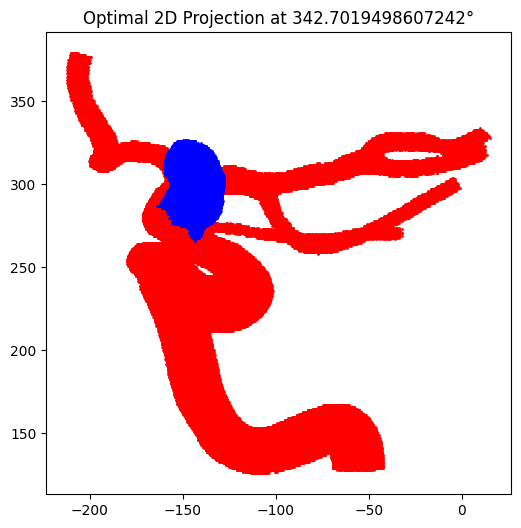

In [149]:
import numpy as np
import matplotlib.pyplot as plt

# Define the angle for the 2D projection
angle = 342.7019498607242 # Replace with your desired angle

# Convert the angle to radians
angle_rad = np.radians(angle)
1# Define the projection direction
projection_vector = np.array([np.cos(angle_rad), np.sin(angle_rad), 0])

# Project the 3D points onto the 2D plane
projected_x_vessels = x1 * projection_vector[0] + y1 * projection_vector[1]
projected_y_vessels = z1  # Keep the z-coordinate as the second axis for the 2D plot

projected_x_aneurysm = x2 * projection_vector[0] + y2 * projection_vector[1]
projected_y_aneurysm = z2

# Flip the x-axis to correct for mirroring (if needed)
projected_x_vessels = -projected_x_vessels
projected_x_aneurysm = -projected_x_aneurysm

# Generate the 2D plot
plt.figure(figsize=(6, 6))
plt.scatter(projected_x_vessels, projected_y_vessels, s=1, c='red', label='Vessels')
plt.scatter(projected_x_aneurysm, projected_y_aneurysm, s=1, c='blue', label='Aneurysm')
plt.title(f'Optimal 2D Projection at {angle}°')
plt.grid(False)

# Save the plot as a PNG file
plt.savefig(r'D:\Team_challenge\results\C002_least_overlap.png', dpi=300)

# Show the plot
plt.show()


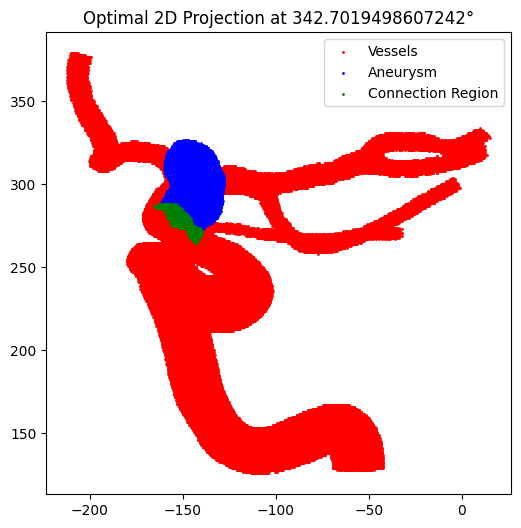

In [150]:
# Project the 3D points onto the 2D plane
projected_x_vessels = x1 * projection_vector[0] + y1 * projection_vector[1]
projected_y_vessels = z1  # Keep the z-coordinate as the second axis for the 2D plot

projected_x_aneurysm = x2 * projection_vector[0] + y2 * projection_vector[1]
projected_y_aneurysm = z2

projected_x_connection = x * projection_vector[0] + y * projection_vector[1]
projected_y_connection = z  # Keep the z-coordinate as the second axis for the 2D plot

# Ensure all projected arrays have the same length
if len(projected_x_vessels) != len(projected_y_vessels):
    raise ValueError("Mismatch in dimensions of projected_x_vessels and projected_y_vessels")

if len(projected_x_aneurysm) != len(projected_y_aneurysm):
    raise ValueError("Mismatch in dimensions of projected_x_aneurysm and projected_y_aneurysm")

if len(projected_x_connection) != len(projected_y_connection):
    raise ValueError("Mismatch in dimensions of projected_x_connection and projected_y_connection")

# Flip the x-axis to correct for mirroring (if needed)
projected_x_vessels = -projected_x_vessels
projected_x_aneurysm = -projected_x_aneurysm
projected_x_connection = -projected_x_connection

# Generate the 2D plot
plt.figure(figsize=(6, 6))
plt.scatter(projected_x_vessels, projected_y_vessels, s=1, c='red', label='Vessels')
plt.scatter(projected_x_aneurysm, projected_y_aneurysm, s=1, c='blue', label='Aneurysm')
plt.scatter(projected_x_connection, projected_y_connection, s=1, c='green', label='Connection Region')
plt.title(f'Optimal 2D Projection at {angle}°')
plt.legend()
plt.grid(False)

# Save the plot as a PNG file
plt.savefig(r'D:\Team_challenge\results\2D_projection_with_connection.png', dpi=300)

# Show the plot
plt.show()
